In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

# Tensorflow import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Dense,
    ReLU,
    Softmax,
    BatchNormalization,
    Dropout,
)
from tensorflow.random import set_seed

In [ ]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls="dashed")
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history["val_" + metric])
        ax[idx].legend([metric, "val_" + metric])


def ConfusionMatrix(model, ds, label_list):
    # Note: This logic doesn't work with shuffled datasets
    plt.figure(figsize=(15, 15))
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = metrics.confusion_matrix(true_categories, predicted_categories)  # last batch
    sns.heatmap(
        cm,
        annot=True,
        xticklabels=label_list,
        yticklabels=label_list,
        cmap="YlGnBu",
        fmt="g",
    )
    plt.show()


def testAccuracy(model):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    class_names = test_data.class_names
    predicted_categories = tf.argmax(y_pred, axis=1)
    test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
    print(f"\nTest Accuracy: {test_acc:.2f}%\n")


def plot_image(pred_array, true_label, img, class_names):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(pred_array)
    if predicted_label == true_label:
        color = "blue"
    else:
        color = "red"

    plt.xlabel(
        "{} {:2.0f}% ".format(
            class_names[predicted_label],
            100 * np.max(pred_array),
        ),
        color=color,
    )


def predictions(model):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    class_names = test_data.class_names
    # Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
    indices = random.sample(range(len(images)), 15)
    # Color correct predictions in blue and incorrect predictions in red.
    num_rows = 5
    num_cols = 3
    num_images = num_rows * num_cols
    plt.figure(figsize=(4 * num_cols, 2 * num_rows))
    for i, index in enumerate(indices):
        plt.subplot(num_rows, num_cols, i + 1)
        plot_image(y_pred[index], true_categories[index], images[index], class_names)
    plt.tight_layout()
    plt.show()


checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "final_model.h5", save_best_only=True
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

In [ ]:
set_seed(111)  # set random seed

# To supress any warnings during the flow
import warnings

warnings.filterwarnings("ignore")

In [ ]:
class_dirs = os.listdir(
    "vegetables_images/train"
)  # list all directories inside "train" folder

image_dict = {}  # dict to store image array(key) for every class(value)

count_dict = {}  # dict to store count of files(key) for every class(value)

# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f"vegetables_images/train/{cls}/*")
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict[cls] = tf.keras.utils.load_img(image_path)

**Exploratory Data Analysis**


In [ ]:
## Viz Random Sample from each class
plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls, img) in enumerate(image_dict.items()):
    # create a subplot axis
    ax = plt.subplot(4, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title
    plt.title(f"{cls}, {img.size}")
    plt.axis("off")

In [ ]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame(
    {
        "class": count_dict.keys(),  # keys of count_dict are class labels
        "count": count_dict.values(),  # value of count_dict contain counts of each class
    }
)
print("Count of training samples per class:\n", df_count_train)

In [ ]:
# draw a bar plot using pandas in-built plotting function
plt.figure(figsize=(15, 12))
df_count_train.plot.bar(x="class", y="count", title="Training Data Count per class")
plt.show()

**LOADING DATASET**


In [ ]:
print("\nLoading Train Data...")
train_data = tf.keras.utils.image_dataset_from_directory(
    "vegetables_images/train",
    shuffle=True,
)

print("\nLoading Validation Data...")
val_data = tf.keras.utils.image_dataset_from_directory(
    "vegetables_images/validation",
    shuffle=False,
)

print("\nLoading Test Data...")
test_data = tf.keras.utils.image_dataset_from_directory(
    "vegetables_images/test",
    shuffle=False,
)

**Data Preprocessing**


In [ ]:
height, width = 224, 224

# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(height, width),  # Shape Preprocessing
        layers.Rescaling(1.0 / 255),  # Value Preprocessing
    ],
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

In [ ]:
num_classes = 15
hidden_size_1 = 1024
hidden_size_2 = 256

**Transfer Learning**


**MobileNet**


In [ ]:
pretrained_mobilenet_model = tf.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=[height, width, 3]
)
pretrained_mobilenet_model.trainable = False
mobilenet_model = tf.keras.Sequential(
    [
        pretrained_mobilenet_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(15, activation="softmax"),
    ]
)

In [ ]:
mobilenet_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
mobilenet_model.summary()

In [ ]:
history_mobilenet = mobilenet_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

In [ ]:
training_plot(["loss", "accuracy"], history_mobilenet)

In [ ]:
if not os.path.exists("model"):
    os.makedirs("model")

mobilenet_model.save("model/mobilenet_model")

In [ ]:
testAccuracy(mobilenet_model)

**Verificacion manual del modelo**


In [ ]:
from tensorflow import keras

mobilenet_model = keras.models.load_model("model/mobilenet_model")
mobilenet_model.metrics_names

In [ ]:
predictions(mobilenet_model)

In [ ]:
from typing import List, Tuple

class_labels = [
    "Bean",
    "Bitter_Gourd",
    "Bottle_Gourd",
    "Brinjal",
    "Broccoli",
    "Cabbage",
    "Capsicum",
    "Carrot",
    "Cauliflower",
    "Cucumber",
    "Papaya",
    "Potato",
    "Pumpkin",
    "Radish",
    "Tomato",
]


def display_image(image_path):
    veg_img = plt.imread(image_path)
    plt.imshow(veg_img)
    plt.show()


def translate_pred(prediction: np.array, class_labels: List[str]) -> Tuple[str, float]:
    """Translate model prediction into human-readable format for multi-class classification.

    Args:
        prediction (np.array): Model prediction array.
        class_labels (List[str]): List of class labels.

    Returns:
        Tuple[str, float]: Tuple containing the predicted class and its corresponding confidence score.
    """
    max_prob_index = np.argmax(prediction)
    predicted_class = class_labels[max_prob_index]
    confidence_score = prediction[0][max_prob_index] * 100
    return predicted_class, confidence_score

In [ ]:
def model_predict(image_uri: str):
    import numpy as np
    from keras.preprocessing.image import load_img, img_to_array
    from tensorflow.keras.applications.mobilenet import preprocess_input

    display_image(image_uri)

    # Load the image
    img_width, img_height = 224, 224
    my_image = load_img(image_uri, target_size=(img_width, img_height))

    # Convert the image to an array and preprocess it
    img_arr = img_to_array(my_image)
    img_arr = np.expand_dims(img_arr, axis=0)
    preprocessed_img = preprocess_input(img_arr)

    prediction = mobilenet_model.predict(preprocessed_img)
    # Assuming `prediction` is the output prediction array from your model
    predicted_class, confidence_score = translate_pred(prediction, class_labels)

    # Print the prediction
    print(f"It's a {predicted_class} ({confidence_score:.2f}%)")

In [ ]:
def predict_single_image(model, image_uri: str):
    import tensorflow as tf
    import matplotlib.pyplot as plt
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    import random

    # Load the image
    img_width, img_height = 224, 224
    my_image = load_img(image_uri, target_size=(img_width, img_height))

    # Convert the image to an array and preprocess it
    img_arr = img_to_array(my_image)
    img_arr = tf.expand_dims(img_arr, axis=0)
    preprocessed_img = (
        img_arr / 255.0
    )  # Assuming the model expects inputs in [0, 1] range

    # Predict the class of the preprocessed image
    prediction = model.predict(preprocessed_img)
    predicted_class = tf.argmax(prediction, axis=1).numpy()[0]
    max_prob_index = np.argmax(prediction)
    confidence_score = prediction[0][max_prob_index] * 100

    # Get the class names from the dataset
    class_names = test_data.class_names

    # Display the prediction
    plt.imshow(my_image)
    plt.axis("off")
    plt.title(f"Predicted: {class_names[predicted_class]}")
    plt.show()
    print(f"It's a {predicted_class} ({confidence_score:.2f}%)")

In [ ]:
predict_single_image(mobilenet_model, "vegetables_images/test/Papaya/1214.jpg")

In [ ]:
model_predict("vegetables_images/test/Papaya/1198.jpg")

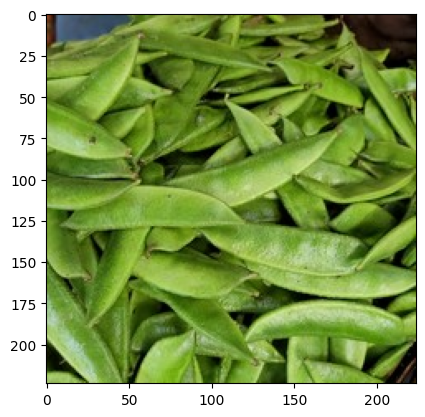

1/1 [==============================] - 0s 27ms/step
It's a Bean (100.00%)


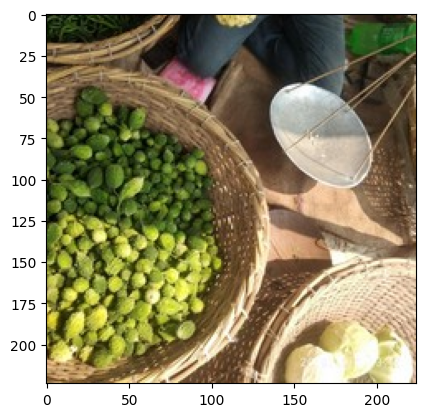

1/1 [==============================] - 0s 24ms/step
It's a Bitter_Gourd (73.63%)


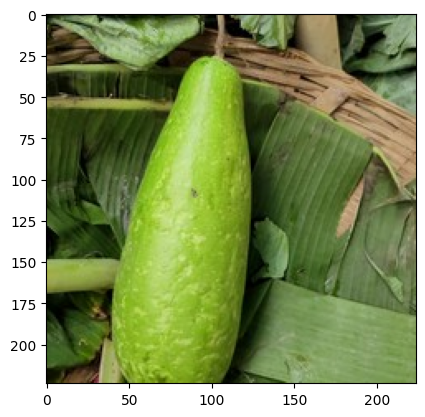

1/1 [==============================] - 0s 27ms/step
It's a Bottle_Gourd (99.93%)


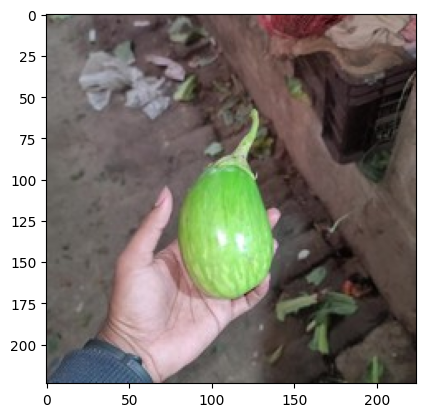

1/1 [==============================] - 0s 27ms/step
It's a Brinjal (99.77%)


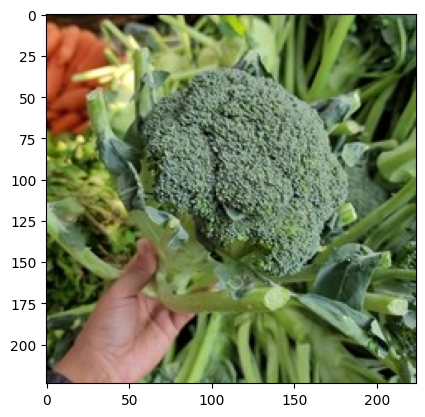

1/1 [==============================] - 0s 25ms/step
It's a Broccoli (99.96%)


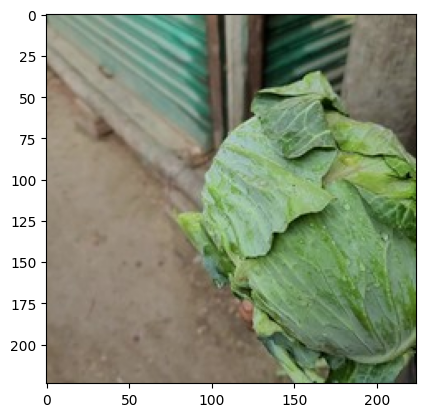

1/1 [==============================] - 0s 37ms/step
It's a Cabbage (96.68%)


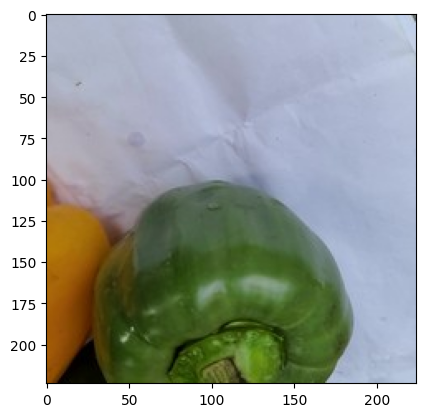

1/1 [==============================] - 0s 26ms/step
It's a Capsicum (98.54%)


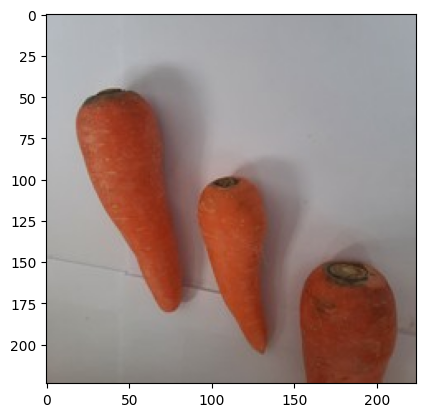

1/1 [==============================] - 0s 28ms/step
It's a Carrot (99.99%)


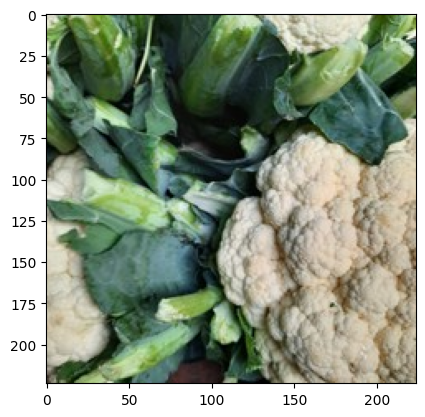

1/1 [==============================] - 0s 30ms/step
It's a Cauliflower (99.98%)


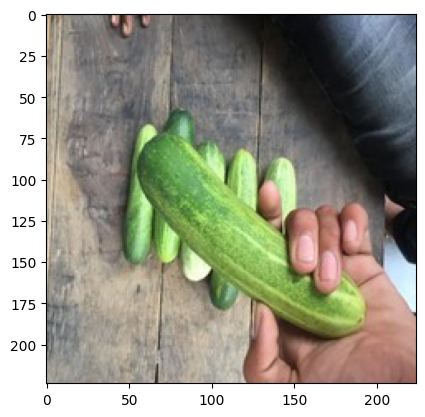

1/1 [==============================] - 0s 26ms/step
It's a Cucumber (99.94%)


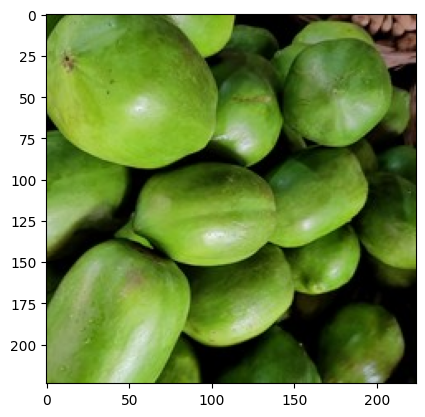

1/1 [==============================] - 0s 30ms/step
It's a Papaya (98.19%)


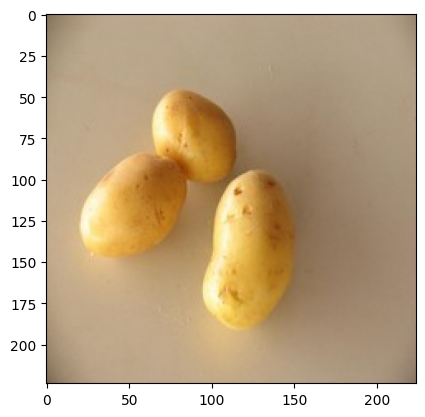

1/1 [==============================] - 0s 41ms/step
It's a Potato (99.98%)


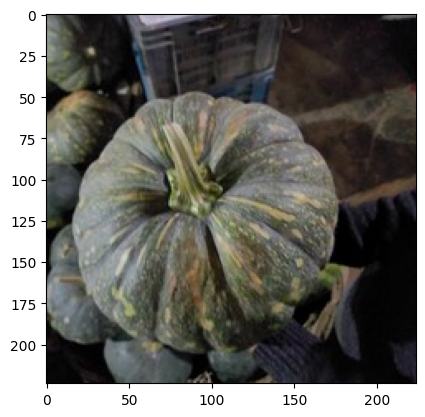

1/1 [==============================] - 0s 37ms/step
It's a Pumpkin (100.00%)


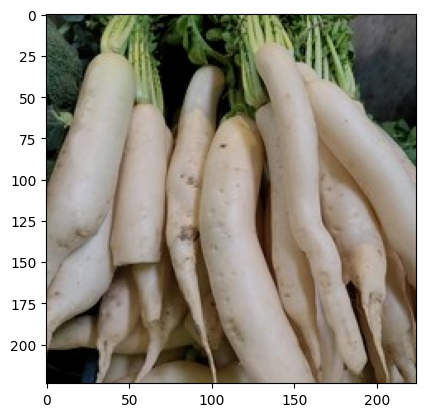

1/1 [==============================] - 0s 25ms/step
It's a Radish (100.00%)


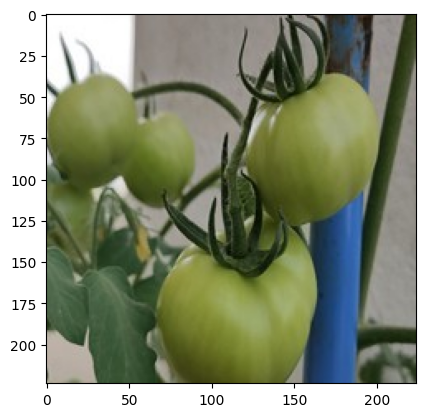

1/1 [==============================] - 0s 28ms/step
It's a Tomato (99.96%)


In [45]:


# Define the base directory where the images are stored
base_dir = "vegetables_images/test"



# Function to randomly select one image per class label and apply model_predict
def predict_random_images(model_predict_function):
    for label in class_labels:
        # Get the list of image files for the current label
        label_dir = os.path.join(base_dir, label)
        image_files = os.listdir(label_dir)
        # Choose a random image file
        random_image_file = random.choice(image_files)
        # Construct the full path to the randomly chosen image
        image_uri = os.path.join(label_dir, random_image_file)
        # Apply the model_predict function to the random image
        model_predict_function(image_uri)

# Define a wrapper function to apply model prediction to an image URI
def predict_with_model(image_uri):
    # Call the model_predict function with the image_uri
    model_predict(image_uri)

# Call the predict_random_images function with the wrapper function as argument
predict_random_images(predict_with_model)

